# 金-网交易模型
# 单核测试

In [7]:
from __future__ import (absolute_import, division, print_function,unicode_literals)
import math
from warnings import simplefilter
import pandas as pd
import numpy as np
simplefilter(action='ignore', category=FutureWarning)
import logging
import backtrader as bt
import datetime
%matplotlib notebook

# # ================================================= 日志功能 =============================================================
logger = logging.getLogger(name='回测记录') # 日志器
console_handler = logging.StreamHandler() # 控制台处理器
file_handler = logging.FileHandler('./log.txt', mode='a', encoding='utf-8') # 文本处理器
# 显示等级
logger.setLevel(level='INFO')
console_handler.setLevel(level='INFO')
file_handler.setLevel(level='INFO')
# 格式
console_fmt = '%(asctime)s - %(message)s'
file_fmt    = '%(asctime)s - %(message)s'
# 格式器
fmt1 = logging.Formatter(fmt=console_fmt)
fmt2 = logging.Formatter(fmt= file_fmt)
# 消息处理器中加入格式器
console_handler.setFormatter(fmt1)
file_handler.setFormatter(fmt2)
# 日志器中加入消息处理器
logger.addHandler(console_handler)
logger.addHandler(file_handler)
def logoutput(mes):
    logger.info(str(mes))
# # -----------------------------------------------------------------------------------------------------------------------



# # ============================================== 对敲网格交易模型 ======================================================
class GridStrategy(bt.Strategy):
    global para_dict
    '''params：默认参数'''
    params = (
        dict(
            period=150,
            rebuild_day = 2,
            first_hand = 5,
            grids = 20,
            discount = 0.45,
            knock_rate = 0.02,
            knock_hand = 1,
            latest_date = datetime.date(2019,10,1),
            time_delta = 3*365,
            by_hand = int(100)
            )
                    )

    def log(self,text,dt=None):
        '''日志记录函数'''
        date = dt or self.datas[0].datetime.date(0)
        logoutput(text)

    def __init__(self):
        '''对收盘价整条线的引用'''
        self.dataclose = self.datas[0].close # 引用收盘价
        '''跟踪待处理的订单（定义一个空订单）'''
        self.order = None
        '''定义一个空的DataFrame'''
        # self.para = pd.DataFrame(data={'pos':[0]},index = ['买1','买2','买3','买4','买5','买6','买7','买8','买9','买10','买11','买12','买13','买14','买15'])
        '''跟踪上次交易的价格，用在对敲交易中'''
        self.lastdeal = None
        '''跟踪上次建仓的行号，用来判断是否要重新建仓'''
        # self.started_pos = 0
        '''跟踪最小资金池'''
        self.minist_cash = 10000000
        '''跟踪最新价值'''
        self.value = 50000
        '''跟踪最大回撤'''
        self.max_draw_down = 0
        '''添加简单移动平均指标'''
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        '''50000块钱均分到65手'''
        self.one_hand = int(10000000)
        '''随机的日期:周期三年'''
        self.end_time = self.params.latest_date
        self.start_time = self.end_time - datetime.timedelta(days=self.params.time_delta)
        '''跟踪最低的持仓位置'''
        self.lowest_pos = '买1'
        self.p1 = False
        self.p2 = False
        self.p2_top = 10000000
        self.p2_high = 10000000
        self.p2_low = 0
        self.pos1 = 0
        self.pos2 = [[1,0,0,0],[2,0,0,0],[3,0,0,0],[4,0,0,0],[5,0,0,0]]
        self.p2_amount = 0

    def notify_order(self,order):
        '''订单的判别 & 处理'''
        '''    1.订单在 提交 → 成交 的过程中'''
        if order.status in [order.Submitted, order.Accepted]:  # 订单在 提交 → 成交 的过程中
            return                                             # 无事可做
            '''2.订单 成交'''
        elif order.status in [order.Completed]:
            if    order.isbuy(): # 订单是买单
                # self.log(f'买单成交, 成交价格：{order.executed.price}')
                # self.bar_executed = len(self) # ！！！记录买单成交的bar！！！
                pass
            elif order.issell(): # 订单是卖单
                # self.log(f'卖单成交, 成交价格：{order.executed.price}')
                pass
            '''3.订单 异常'''
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            # self.log(('! ! ! 订单被取消 or 订单远离价格无法成交 or 订单被拒绝 ! ! !'))
            pass
            '''4.判断完成后，重置订单状态'''
        self.order = None

        

    def notify_trade(self, trade):
        '''一次网格交易走完'''
        if trade.isclosed:
            # self.log(f'-- 本次网格交易走完，本次交易的 毛利润:【{trade.pnl}】净利润:【{trade.pnlcomm}】--\n')
            pass

            '''一次网格交易没走完'''
        else:
            return

    def next(self):
        self.one_hand = math.floor(self.broker.getvalue()/(75-self.pos1)/self.dataclose[0])
        
        
        '''1.保证程序跑在随机的3年行情里面'''
        if self.datas[0].datetime.date(0) < self.start_time or self.datas[0].datetime.date(0) > self.end_time:
            return

        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
        '''2.查看订单跟踪器中是否有未处理订单'''
        if self.order:
            return  # 有未处理订单直接不执行跳过
        else:
            pass    # 无未处理订单继续下面代码
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
        '''3.对敲 - 核心交易判断代码'''
        # 3.1 没有仓位，而且跑出了金字塔 ---- 无仓，（跑过塔 or 距上次建仓超过n个交易日）  ----> 重新建仓

        if self.sma[0] <= self.dataclose[0]:
            '''！尝试建仓！'''
            if self.p1 == False:
                self.p1 = True
                # self.log(f'  =====  "对敲"系统，开始建仓！  =====  ')
                '''下买单，并且赋值给订单跟踪器 --来避免重复下单'''
                self.order = self.buy(size = int(self.params.first_hand * self.one_hand))
                self.pos1 = self.params.first_hand # 初始手数first_hand手
                self.lastdeal = self.dataclose[0] # 更新本次交易的价格，用在对敲交易中
                '''！继续交易！'''
            else:
                # 1.价格下降x，敲买单
                if self.dataclose[0] < self.lastdeal:
                    # 敲完仓位不能超过10手
                    if self.pos1 + self.params.knock_hand <= 30:
                        self.pos1 += self.params.knock_hand
                        self.order = self.buy(size = int(self.params.knock_hand * self.one_hand)) # 对敲手数
                        # self.log(f'对敲 - “买” - ，对敲持仓：{self.pos1}。')
                        self.lastdeal = self.dataclose[0]
                    else:
                        self.p2 = True
                        self.p2_top = self.sma[0]
                        self.p2_high = (self.dataclose[0]/self.sma[0])*self.sma[0]
                        self.p2_low = 0.50*self.sma[0]
                        self.p2_amount = 75-self.pos1
                
                # 2.价格上涨x，敲卖单
                elif self.dataclose[0] > (1+self.params.knock_rate) * self.lastdeal:
                    # 敲完仓位不能为负
                    if self.pos1 - self.params.knock_hand >= 0:
                        self.pos1 -= self.params.knock_hand
                        self.order = self.sell(size = int(self.params.knock_hand * self.one_hand)) # 对敲手数
                        # self.log(f'对敲 - “卖” - ，对敲持仓：{self.pos1}。')
                        self.lastdeal = self.dataclose[0]
                    else:
                        self.order = self.sell(size = self.pos1 * self.one_hand)
                        self.pos1 = 0
                        # self.log(f'对敲 - “卖” - ，对敲持仓：{self.pos1}。')
                        self.lastdeal = self.dataclose[0]
        elif self.dataclose[0] > self.sma[0] * 1.25 + self.params.knock_rate:
            self.order = self.sell(size = self.pos1 * self.one_hand)
            self.pos1 = 0
            # self.log(f'对敲 - “卖” - ，对敲持仓：{self.pos1}。')
            self.lastdeal = self.dataclose[0]
        elif self.dataclose[0] < self.sma[0] * 0.85:
            self.p2 = True
            self.p2_top = self.sma[0]
            self.p2_high = (self.dataclose[0]/self.sma[0])*self.sma[0]
            self.p2_low = 0.77*self.sma[0]
            self.p2_amount = 75-self.pos1
            
            
            
        if self.p2 == True:
            x = 1-(self.p2_low/self.sma[0])**(1/5)
            for i in range(len(self.pos2)):
                self.pos2[i][1] = self.p2_high*((1-0.5)**(i))
                self.pos2[i][2] = (1-self.pos2[i][1]/self.p2_top+1)*self.p2_top
        if self.dataclose[0] > self.p2_high:
            self.p2 = False

        for i in range(len(self.pos2)):
            if (self.pos2[i][3] == 0) & (self.dataclose[0] <= self.pos2[i][1]):
                self.pos2[i][3] = math.ceil(  (self.p2_amount-10)/5+i  )
                self.order = self.buy(size = int(self.pos2[i][3] * self.one_hand))
            if (self.pos2[i][3] > 0) & (self.dataclose[0] >= self.pos2[i][2]):
                self.order = self.sell(size = int(self.pos2[i][3] * self.one_hand))
                self.pos2[i][3] = 0
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
        '''0.记录最小的cash值'''
        # 1.cash
        if self.stats.broker.cash[0] < self.minist_cash:
            self.minist_cash = self.stats.broker.cash[0]
        # 2.value
        self.value = self.broker.getvalue()
        # 3.maxdrawdown
        if self.stats.drawdown.drawdown[0]/100*self.value > self.max_draw_down:
            self.max_draw_down = self.stats.drawdown.drawdown[0]/100*self.value
        
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    
    def stop(self):
        
        a1 = self.value-50000 # 最终盈利
        b1 = 50000-self.minist_cash # 使用本金
        c1 =a1/b1
        self.log('|%d|%.2f|%d|%d|%d|%.4f|%d| ===>最终值|%.2f|%.2f|%.2f|%.2f|%s' % (
            self.params.period,
            self.params.discount,
            self.params.rebuild_day,
            self.params.first_hand,
            self.params.grids,
            self.params.knock_rate,
            self.params.knock_hand,
            a1,b1,c1,
            self.max_draw_down/b1,
            self.lowest_pos)
                 )








def start_run(period=200,
              discount=0.45,
              rebuild_day=2,
              first_hand=5,
              grids=20,
              knock_rate=0.02,
              knock_hand=1,
              end=(2016,1,1),
              time_delta=365*3):
    # 创建‘大脑’。Cerebro引擎被实例化了
    cerebro = bt.Cerebro()

    # 添加一个策略
    cerebro.addstrategy(GridStrategy,
                        period=period,
                        discount=discount,
                        rebuild_day=rebuild_day,
                        first_hand=first_hand,
                        grids=grids,
                        knock_rate=knock_rate,
                        knock_hand=knock_hand,
                        time_delta=time_delta,
                        latest_date=datetime.date(end[0],end[1],end[2]))

    # 喂入pandas数据
    df = pd.read_csv('159919.csv')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index(['date'])
    data = bt.feeds.PandasData(
        dataname=df
        )



    # 把数据槽添加到大脑引擎中
    cerebro.adddata(data)

    # 创建初始金额
    cerebro.broker.setcash(50000.0)

    # 创建观察器
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addobserver(bt.observers.TimeReturn)

    # 创建分析器
    # cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')


    # 设定佣金为万0.5，0.5除以10000
    cerebro.broker.setcommission(commission=0.00005)

    #‘大脑’运行。生成的cerebro实例被告知运行（遍历数据）
    cerebro.run()
    cerebro.plot()





2021-11-09 17:19:05,393 - |300|0.45|1|5|20|0.0100|1| ===>最终值|30254.24|32488.41|0.93|0.50|买1
2021-11-09 17:19:05,393 - |300|0.45|1|5|20|0.0100|1| ===>最终值|30254.24|32488.41|0.93|0.50|买1
2021-11-09 17:19:05,393 - |300|0.45|1|5|20|0.0100|1| ===>最终值|30254.24|32488.41|0.93|0.50|买1
2021-11-09 17:19:05,393 - |300|0.45|1|5|20|0.0100|1| ===>最终值|30254.24|32488.41|0.93|0.50|买1


<IPython.core.display.Javascript object>


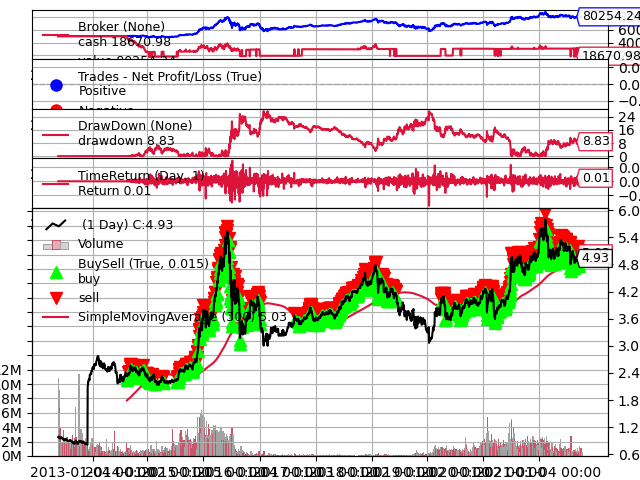

In [8]:
'''
def start_run(multiple,
              
              discount=0.45,
              rebuild_day=2,
              first_hand=5,
              grids=20,
              knock_rate=0.02,
              knock_hand=1,
              end=(2016,1,1),
              time_delta=365*3):
'''
for i in range(100,300):
    for j in range(2015,2022):
        for k in range(1,12):
            s=1
            
start_run(period=300,
          rebuild_day=1,
          first_hand=5,
          grids=20,
          knock_rate=0.01,
          knock_hand=1,
          end=(2021,11,21),
          time_delta=365*15)

2021-11-09 17:15:40,107 - |300|0.45|1|5|20|0.0100|1| ===>最终值|55531.22|41659.56|1.33|0.24|买1


<IPython.core.display.Javascript object>


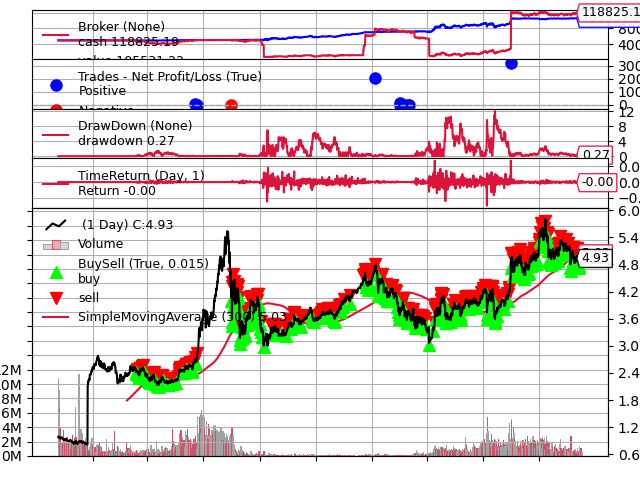

In [2]:
'''
def start_run(multiple,
              
              discount=0.45,
              rebuild_day=2,
              first_hand=5,
              grids=20,
              knock_rate=0.02,
              knock_hand=1,
              end=(2016,1,1),
              time_delta=365*3):
'''
for i in range(100,300):
    for j in range(2015,2022):
        for k in range(1,12):
            s=1
            
start_run(period=300,
          rebuild_day=1,
          first_hand=5,
          grids=20,
          knock_rate=0.01,
          knock_hand=1,
          end=(2021,11,21),
          time_delta=365*15)

# 多核参数调试

In [1]:
%%writefile test.py
from __future__ import (absolute_import, division, print_function,unicode_literals)
import math
from warnings import simplefilter
import pandas as pd
import numpy as np
simplefilter(action='ignore', category=FutureWarning)
import logging
import backtrader as bt
import datetime

# # ================================================= 日志功能 =============================================================
logger = logging.getLogger(name='回测记录') # 日志器
console_handler = logging.StreamHandler() # 控制台处理器
file_handler = logging.FileHandler('./log.txt', mode='a', encoding='utf-8') # 文本处理器
# 显示等级
logger.setLevel(level='INFO')
console_handler.setLevel(level='INFO')
file_handler.setLevel(level='INFO')
# 格式
console_fmt = '%(asctime)s - %(message)s'
file_fmt    = '%(asctime)s - %(message)s'
# 格式器
fmt1 = logging.Formatter(fmt=console_fmt)
fmt2 = logging.Formatter(fmt= file_fmt)
# 消息处理器中加入格式器
console_handler.setFormatter(fmt1)
file_handler.setFormatter(fmt2)
# 日志器中加入消息处理器
logger.addHandler(console_handler)
logger.addHandler(file_handler)
def logoutput(mes):
    logger.info(str(mes))
# # -----------------------------------------------------------------------------------------------------------------------




# # ============================================== 对敲网格交易模型 ======================================================
class GridStrategy(bt.Strategy):
    global para_dict
    '''params：默认参数'''
    params = (
        dict(
            period=150,
            rebuild_day = 2,
            first_hand = 5,
            grids = 20,
            discount = 0.45,
            knock_rate = 0.02,
            knock_hand = 1,
            latest_date = datetime.date(2019,10,1),
            time_delta = 3*365,
            by_hand = int(100)
            )
                    )

    def log(self,text,dt=None):
        '''日志记录函数'''
        date = dt or self.datas[0].datetime.date(0)
        logoutput(text)

    def __init__(self):
        '''对收盘价整条线的引用'''
        self.dataclose = self.datas[0].close # 引用收盘价
        '''跟踪待处理的订单（定义一个空订单）'''
        self.order = None
        '''定义一个空的DataFrame'''
        # self.para = pd.DataFrame(data={'pos':[0]},index = ['买1','买2','买3','买4','买5','买6','买7','买8','买9','买10','买11','买12','买13','买14','买15'])
        '''跟踪上次交易的价格，用在对敲交易中'''
        self.lastdeal = None
        '''跟踪上次建仓的行号，用来判断是否要重新建仓'''
        # self.started_pos = 0
        '''跟踪最小资金池'''
        self.minist_cash = 10000000
        '''跟踪最新价值'''
        self.value = 50000
        '''跟踪最大回撤'''
        self.max_draw_down = 0
        '''添加简单移动平均指标'''
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.period)
        '''50000块钱均分到65手'''
        self.one_hand = int(10000000)
        '''随机的日期:周期三年'''
        self.end_time = self.params.latest_date
        self.start_time = self.end_time - datetime.timedelta(days=self.params.time_delta)
        '''跟踪最低的持仓位置'''
        self.lowest_pos = '买1'
        self.p1 = False
        self.p2 = False
        self.p2_top = 10000000
        self.p2_high = 10000000
        self.p2_low = 0
        self.pos1 = 0
        self.pos2 = [[1,0,0,0],[2,0,0,0],[3,0,0,0],[4,0,0,0],[5,0,0,0]]
        self.p2_amount = 0

    def notify_order(self,order):
        '''订单的判别 & 处理'''
        '''    1.订单在 提交 → 成交 的过程中'''
        if order.status in [order.Submitted, order.Accepted]:  # 订单在 提交 → 成交 的过程中
            return                                             # 无事可做
            '''2.订单 成交'''
        elif order.status in [order.Completed]:
            if    order.isbuy(): # 订单是买单
                # self.log(f'买单成交, 成交价格：{order.executed.price}')
                # self.bar_executed = len(self) # ！！！记录买单成交的bar！！！
                pass
            elif order.issell(): # 订单是卖单
                # self.log(f'卖单成交, 成交价格：{order.executed.price}')
                pass
            '''3.订单 异常'''
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            # self.log(('! ! ! 订单被取消 or 订单远离价格无法成交 or 订单被拒绝 ! ! !'))
            pass
            '''4.判断完成后，重置订单状态'''
        self.order = None

        

    def notify_trade(self, trade):
        '''一次网格交易走完'''
        if trade.isclosed:
            # self.log(f'-- 本次网格交易走完，本次交易的 毛利润:【{trade.pnl}】净利润:【{trade.pnlcomm}】--\n')
            pass

            '''一次网格交易没走完'''
        else:
            return

    def next(self):
        self.one_hand = math.floor(self.broker.getvalue()/(75-self.pos1)/self.dataclose[0])
        
        
        '''1.保证程序跑在随机的3年行情里面'''
        if self.datas[0].datetime.date(0) < self.start_time or self.datas[0].datetime.date(0) > self.end_time:
            return

        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
        '''2.查看订单跟踪器中是否有未处理订单'''
        if self.order:
            return  # 有未处理订单直接不执行跳过
        else:
            pass    # 无未处理订单继续下面代码
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
        '''3.对敲 - 核心交易判断代码'''
        # 3.1 没有仓位，而且跑出了金字塔 ---- 无仓，（跑过塔 or 距上次建仓超过n个交易日）  ----> 重新建仓

        if self.sma[0] <= self.dataclose[0]:
            '''！尝试建仓！'''
            if self.p1 == False:
                self.p1 = True
                # self.log(f'  =====  "对敲"系统，开始建仓！  =====  ')
                '''下买单，并且赋值给订单跟踪器 --来避免重复下单'''
                self.order = self.buy(size = int(self.params.first_hand * self.one_hand))
                self.pos1 = self.params.first_hand # 初始手数first_hand手
                self.lastdeal = self.dataclose[0] # 更新本次交易的价格，用在对敲交易中
                '''！继续交易！'''
            else:
                # 1.价格下降x，敲买单
                if self.dataclose[0] < self.lastdeal:
                    # 敲完仓位不能超过10手
                    if self.pos1 + self.params.knock_hand <= 30:
                        self.pos1 += self.params.knock_hand
                        self.order = self.buy(size = int(self.params.knock_hand * self.one_hand)) # 对敲手数
                        # self.log(f'对敲 - “买” - ，对敲持仓：{self.pos1}。')
                        self.lastdeal = self.dataclose[0]
                    else:
                        self.p2 = True
                        self.p2_top = self.sma[0]
                        self.p2_high = (self.dataclose[0]/self.sma[0])*self.sma[0]
                        self.p2_low = 0.50*self.sma[0]
                        self.p2_amount = 75-self.pos1
                
                # 2.价格上涨x，敲卖单
                elif self.dataclose[0] > (1+self.params.knock_rate) * self.lastdeal:
                    # 敲完仓位不能为负
                    if self.pos1 - self.params.knock_hand >= 0:
                        self.pos1 -= self.params.knock_hand
                        self.order = self.sell(size = int(self.params.knock_hand * self.one_hand)) # 对敲手数
                        # self.log(f'对敲 - “卖” - ，对敲持仓：{self.pos1}。')
                        self.lastdeal = self.dataclose[0]
                    else:
                        self.order = self.sell(size = self.pos1 * self.one_hand)
                        self.pos1 = 0
                        # self.log(f'对敲 - “卖” - ，对敲持仓：{self.pos1}。')
                        self.lastdeal = self.dataclose[0]
        elif self.dataclose[0] > self.sma[0] * 1.25 + self.params.knock_rate:
            self.order = self.sell(size = self.pos1 * self.one_hand)
            self.pos1 = 0
            # self.log(f'对敲 - “卖” - ，对敲持仓：{self.pos1}。')
            self.lastdeal = self.dataclose[0]
        elif self.dataclose[0] < self.sma[0] * 0.85:
            self.p2 = True
            self.p2_top = self.sma[0]
            self.p2_high = (self.dataclose[0]/self.sma[0])*self.sma[0]
            self.p2_low = 0.77*self.sma[0]
            self.p2_amount = 75-self.pos1
            
            
            
        if self.p2 == True:
            x = 1-(self.p2_low/self.sma[0])**(1/5)
            for i in range(len(self.pos2)):
                self.pos2[i][1] = self.p2_high*((1-0.5)**(i))
                self.pos2[i][2] = (1-self.pos2[i][1]/self.p2_top+1)*self.p2_top
        if self.dataclose[0] > self.p2_high:
            self.p2 = False

        for i in range(len(self.pos2)):
            if (self.pos2[i][3] == 0) & (self.dataclose[0] <= self.pos2[i][1]):
                self.pos2[i][3] = math.ceil(  (self.p2_amount-10)/5+i  )
                self.order = self.buy(size = int(self.pos2[i][3] * self.one_hand))
            if (self.pos2[i][3] > 0) & (self.dataclose[0] >= self.pos2[i][2]):
                self.order = self.sell(size = int(self.pos2[i][3] * self.one_hand))
                self.pos2[i][3] = 0
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        
        '''0.记录最小的cash值'''
        # 1.cash
        if self.stats.broker.cash[0] < self.minist_cash:
            self.minist_cash = self.stats.broker.cash[0]
        # 2.value
        self.value = self.broker.getvalue()
        # 3.maxdrawdown
        if self.stats.drawdown.drawdown[0]/100*self.value > self.max_draw_down:
            self.max_draw_down = self.stats.drawdown.drawdown[0]/100*self.value
        
        # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    
    def stop(self):
        
        a1 = self.value-50000 # 最终盈利
        b1 = 50000-self.minist_cash # 使用本金
        c1 =a1/b1
        self.log('|%d|%.2f|%d|%d|%d|%.4f|%d| ===>最终值|%.2f|%.2f|%.2f|%.2f|%s' % (
            self.params.period,
            self.params.discount,
            self.params.rebuild_day,
            self.params.first_hand,
            self.params.grids,
            self.params.knock_rate,
            self.params.knock_hand,
            a1,b1,c1,
            self.max_draw_down/b1,
            self.lowest_pos)
                 )


# ============================================== 日期遍历函数 ================================================
def date_list(start='20180101',end='20190101'):
    a = pd.date_range(start,end,freq='m',closed='left')
    datelist = []
    for i in a:
        k = str(i)[:11].split('-')
        datelist.append(datetime.date(int(k[0]),int(k[1]),int(k[2])))
    return datelist
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ^^^^^^^^^^^        
        
        
if __name__ == '__main__':
    # 创建‘大脑’。Cerebro引擎被实例化了
    cerebro = bt.Cerebro()

    #添加一个策略(带参数遍历)
    cerebro.optstrategy(GridStrategy,
                      period=range(300,301,10),
                      rebuild_day=1,
                      first_hand=5,
                      grids=20,
                      knock_rate=0.01,
                      knock_hand=1,
                      latest_date=date_list(start='2014-08-22',end='2021-11-11'), # 日期遍历函数
                      time_delta=365*1)

    # 喂入pandas数据
    df = pd.read_csv('159919.csv')
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index(['date'])
    data = bt.feeds.PandasData(
        dataname=df,
        # 不接收这个日期更早的数据
        fromdate=datetime.datetime(1990, 3, 3),
        # 不接收晚于这个日期的数据
        todate=datetime.datetime(2021, 10, 15)
        )

    # 把数据槽添加到大脑引擎中
    cerebro.adddata(data)

    # 创建初始金额
    cerebro.broker.setcash(50000.0)

    # 创建观察器
    cerebro.addobserver(bt.observers.Broker)
    cerebro.addobserver(bt.observers.Trades)
    cerebro.addobserver(bt.observers.BuySell)
    cerebro.addobserver(bt.observers.DrawDown)
    cerebro.addobserver(bt.observers.TimeReturn)

    # 创建分析器
    # cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')


    # 设定佣金为万0.5，0.5除以10000
    cerebro.broker.setcommission(commission=0.00005)

    logoutput('| | | | | | | | | | | | ')
    #‘大脑’运行。生成的cerebro实例被告知运行（遍历数据）
    cerebro.run()

Writing test.py


In [2]:
!python test.py
import os
os.remove('test.py') # 做个渣男 运行完就删掉

2021-11-09 17:22:39,041 - | | | | | | | | | | | | 
2021-11-09 17:22:40,838 - |300|0.45|1|5|20|0.0100|1| ===>最终值|580.37|24860.19|0.02|0.12|买1
2021-11-09 17:22:40,840 - |300|0.45|1|5|20|0.0100|1| ===>最终值|1991.41|24902.24|0.08|0.08|买1
2021-11-09 17:22:40,848 - |300|0.45|1|5|20|0.0100|1| ===>最终值|4591.43|24943.23|0.18|0.06|买1
2021-11-09 17:22:40,872 - |300|0.45|1|5|20|0.0100|1| ===>最终值|1595.27|24773.05|0.06|0.11|买1
2021-11-09 17:22:41,305 - |300|0.45|1|5|20|0.0100|1| ===>最终值|5039.13|14231.74|0.35|0.10|买1
2021-11-09 17:22:41,312 - |300|0.45|1|5|20|0.0100|1| ===>最终值|6745.11|16934.67|0.40|0.05|买1
2021-11-09 17:22:41,319 - |300|0.45|1|5|20|0.0100|1| ===>最终值|5672.75|14231.74|0.40|0.10|买1
2021-11-09 17:22:41,372 - |300|0.45|1|5|20|0.0100|1| ===>最终值|8091.31|14231.74|0.57|0.10|买1
2021-11-09 17:22:41,782 - |300|0.45|1|5|20|0.0100|1| ===>最终值|10980.25|14231.74|0.77|0.10|买1
2021-11-09 17:22:41,801 - |300|0.45|1|5|20|0.0100|1| ===>最终值|11665.08|14231.74|0.82|0.10|买1
2021-11-09 17:22:41,812 - |300|0.45|1|